In [1]:
# Characters level ConvNet paper: https://papers.nips.cc/paper/5782-character-level-convolutional-networks-for-text-classification.pdf
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cnn_models as models
import importlib

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, ThresholdedReLU, MaxPooling1D, Flatten, Dropout, ReLU, Activation
from keras.layers import Convolution1D
from keras.layers import Embedding
from keras.callbacks import TensorBoard
from keras.optimizers import Adam, SGD
from keras.utils import multi_gpu_model

Using TensorFlow backend.


In [2]:
train_data = pd.read_csv('../../data/no_tags_lower_train_data.csv', encoding='ISO-8859-1', keep_default_na=False)
test_data = pd.read_csv('../../data/no_tags_lower_test_data.csv', encoding='ISO-8859-1', keep_default_na=False)
dev_data = pd.read_csv('../../data/no_tags_lower_dev_data.csv', encoding='ISO-8859-1', keep_default_na=False)

In [3]:
alphabet = 'abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:\'"/\\|_@#$%^&*~`+-=<>()[]{}'
alphabet_size = len(alphabet)
alphabet_index = {alphabet[i]: i + 1 for i in range(alphabet_size)}
alphabet_index

{'!': 41,
 '"': 45,
 '#': 51,
 '$': 52,
 '%': 53,
 '&': 55,
 "'": 44,
 '(': 64,
 ')': 65,
 '*': 56,
 '+': 59,
 ',': 38,
 '-': 60,
 '.': 40,
 '/': 46,
 '0': 27,
 '1': 28,
 '2': 29,
 '3': 30,
 '4': 31,
 '5': 32,
 '6': 33,
 '7': 34,
 '8': 35,
 '9': 36,
 ':': 43,
 ';': 39,
 '<': 62,
 '=': 61,
 '>': 63,
 '?': 42,
 '@': 50,
 '[': 66,
 '\\': 47,
 ']': 67,
 '^': 54,
 '_': 49,
 '`': 58,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '{': 68,
 '|': 48,
 '}': 69,
 '~': 57}

In [19]:
max_input_size = max(len(row['text']) for _, row in train_data.iterrows())
print('The max input size is: ' + str(max_input_size))

The max input size is: 1390


In [20]:
from statistics import mean 
average_input_size = mean(len(row['text']) for _, row in train_data.iterrows())
print('The average input size is: ' + str(average_input_size))

The average input size is: 68.3684013671875


(array([1.27090e+04, 6.07400e+04, 9.35960e+04, 1.03417e+05, 1.05259e+05,
        1.00208e+05, 9.03710e+04, 8.04980e+04, 7.09430e+04, 6.40500e+04,
        6.00210e+04, 5.98810e+04, 6.63510e+04, 4.78230e+04, 6.33100e+03,
        8.37000e+02, 1.96000e+02, 1.00000e+02, 6.00000e+01, 4.60000e+01,
        4.20000e+01, 2.90000e+01, 3.00000e+01, 3.30000e+01, 2.10000e+01,
        1.80000e+01, 1.40000e+01, 2.00000e+01, 1.60000e+01, 1.40000e+01,
        1.40000e+01, 1.50000e+01, 1.00000e+01, 1.20000e+01, 1.20000e+01,
        1.40000e+01, 1.20000e+01, 4.00000e+00, 8.00000e+00, 9.00000e+00]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
        260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
        390, 400]),
 <a list of 40 Patch objects>)

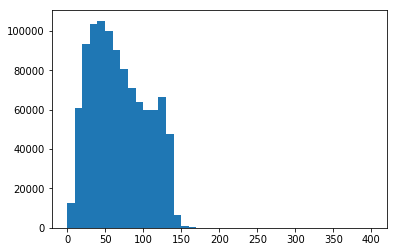

In [7]:
plt.hist([len(row['text']) for _, row in train_data.iterrows()], bins=range(0, 410, 10))

In [4]:
# Cut longer input. We should still be able to capture the meaning of most inputs 
# and meanwhile reduce the parameters number dramatically.
input_length = 150

In [5]:
X_train = models.text_to_padding(train_data, alphabet_index, input_length)
X_test = models.text_to_padding(test_data, alphabet_index, input_length)
X_dev = models.text_to_padding(dev_data, alphabet_index, input_length)

In [6]:
print('tranin: ' + str(X_train.shape))
print('test: ' + str(X_test.shape))
print('dev: ' + str(X_dev.shape))

tranin: (1024000, 150)
test: (320000, 150)
dev: (256000, 150)


In [7]:
Y_train = pd.get_dummies(train_data['sentiment']).values
Y_test = pd.get_dummies(test_data['sentiment']).values
Y_dev = pd.get_dummies(dev_data['sentiment']).values

In [8]:
print('tranin: ' + str(Y_train.shape))
print('test: ' + str(Y_test.shape))
print('dev: ' + str(Y_dev.shape))

tranin: (1024000, 2)
test: (320000, 2)
dev: (256000, 2)


In [9]:
large_filters = [1024, 1024, 1024, 1024, 1024, 1024]
small_filters = [256, 256, 256, 256, 256, 256]
large_fully_connected_dim = [2048, 2048]
small_fully_connected_dim = [1024, 1024]

## Use Small Conv Dimension

In [14]:
params = {
    'epochs': 4,
    'batch_size': 256,
    'alphabet_size': alphabet_size + 1, # All nonalphabet characters are seen as the same character
    'embedding_size': 128,
    'input_length': input_length,
    'filters': small_filters,
    'kernal_size': [7, 7, 3, 3, 3, 3],
    'pool_size': [3, 3, None, None, None, 3],
    'fully_connected_dim': small_fully_connected_dim,
    'dropout_rate': [0.5, 0.5],
    'loss': 'binary_crossentropy',
    'activation': 'sigmoid',
    'lr': 0.0001, # The most sensitive hyparameter. A smaller or greater value cannot converge
}

model = models.get_model(params)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 128)          8960      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 144, 256)          229632    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 48, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 42, 256)           459008    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 14, 256)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 12, 256)           196864    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 10, 256)           196864    
__________

In [15]:
history = model.fit(
    X_train, 
    Y_train, 
    validation_data=[X_dev, Y_dev], 
    epochs=params['epochs'], 
    batch_size=params['batch_size'])

Train on 1024000 samples, validate on 256000 samples
Epoch 1/4
1024000/1024000 [==============================] - 314s 306us/step - loss: 0.5133 - acc: 0.7390 - val_loss: 0.4420 - val_acc: 0.7935
Epoch 2/4
1024000/1024000 [==============================] - 306s 299us/step - loss: 0.4254 - acc: 0.8043 - val_loss: 0.4108 - val_acc: 0.8135
Epoch 3/4
1024000/1024000 [==============================] - 306s 298us/step - loss: 0.3934 - acc: 0.8234 - val_loss: 0.4007 - val_acc: 0.8176
Epoch 4/4
1024000/1024000 [==============================] - 305s 298us/step - loss: 0.3688 - acc: 0.8368 - val_loss: 0.3974 - val_acc: 0.8214


In [16]:
score, acc = model.evaluate(X_test, Y_test, batch_size=params['batch_size'])
print("score: %.8f" % (score))
print("acc: %.8f" % (acc))

320000/320000 [==============================] - 23s 72us/step
score: 0.39603920
acc: 0.82231719


## Use Small Conv Dimension and Shallow Layers

In [12]:
params = {
    'epochs': 5,
    'batch_size': 256,
    'alphabet_size': alphabet_size + 1, # All nonalphabet characters are seen as the same character
    'embedding_size': 128,
    'input_length': input_length,
    'filters': [256, 256, 256],
    'kernal_size': [7, 3, 3],
    'pool_size': [3, 3, 3],
    'fully_connected_dim': [1024],
    'dropout_rate': [0.5],
    'loss': 'binary_crossentropy',
    'activation': 'sigmoid',
    'lr': 0.0001, # The most sensitive hyparameter. A smaller or greater value cannot converge
}

model = models.get_model(params)
history = model.fit(
    X_train, 
    Y_train, 
    validation_data=[X_dev, Y_dev], 
    epochs=params['epochs'], 
    batch_size=params['batch_size'])
score, acc = model.evaluate(X_test, Y_test, batch_size=params['batch_size'])
print("score: %.8f" % (score))
print("acc: %.8f" % (acc))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 150, 128)          8960      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 144, 256)          229632    
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 48, 256)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 46, 256)           196864    
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 15, 256)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 13, 256)           196864    
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 4, 256)            0         
__________

## Use Small Conv Dimension without Dropout

In [13]:
params = {
    'epochs': 5,
    'batch_size': 256,
    'alphabet_size': alphabet_size + 1, # All nonalphabet characters are seen as the same character
    'embedding_size': 128,
    'input_length': input_length,
    'filters': small_filters,
    'kernal_size': [7, 7, 3, 3, 3, 3],
    'pool_size': [3, 3, None, None, None, 3],
    'fully_connected_dim': small_fully_connected_dim,
    'dropout_rate': [0, 0],
    'loss': 'binary_crossentropy',
    'activation': 'sigmoid',
    'lr': 0.0001, # The most sensitive hyparameter. A smaller or greater value cannot converge
}

model = models.get_model(params)
history = model.fit(
    X_train, 
    Y_train, 
    validation_data=[X_dev, Y_dev], 
    epochs=params['epochs'], 
    batch_size=params['batch_size'])
score, acc = model.evaluate(X_test, Y_test, batch_size=params['batch_size'])
print("score: %.8f" % (score))
print("acc: %.8f" % (acc))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 150, 128)          8960      
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 144, 256)          229632    
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 48, 256)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 42, 256)           459008    
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 14, 256)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 12, 256)           196864    
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 10, 256)           196864    
__________

## Use Large Conv Dimension

In [15]:
params = {
    'epochs': 3,
    'batch_size': 256,
    'alphabet_size': alphabet_size + 1, # All nonalphabet characters are seen as the same character
    'embedding_size': 128,
    'input_length': input_length,
    'filters': large_filters,
    'kernal_size': [7, 7, 3, 3, 3, 3],
    'pool_size': [3, 3, None, None, None, 3],
    'fully_connected_dim': large_fully_connected_dim,
    'dropout_rate': [0.5, 0.5],
    'loss': 'binary_crossentropy',
    'activation': 'sigmoid',
    'lr': 0.0001, # The most sensitive hyparameter. A smaller or greater value cannot converge
}

model = models.get_model(params)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 150, 128)          8960      
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 144, 1024)         918528    
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 48, 1024)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 42, 1024)          7341056   
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 14, 1024)          0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 12, 1024)          3146752   
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 10, 1024)          3146752   
__________

In [16]:
history = model.fit(
    X_train, 
    Y_train, 
    validation_data=[X_dev, Y_dev], 
    epochs=params['epochs'], 
    batch_size=params['batch_size'])

Train on 1024000 samples, validate on 256000 samples
Epoch 1/3
1024000/1024000 [==============================] - 1988s 2ms/step - loss: 0.4637 - acc: 0.7737 - val_loss: 0.3935 - val_acc: 0.8238
Epoch 2/3
1024000/1024000 [==============================] - 1980s 2ms/step - loss: 0.3693 - acc: 0.8365 - val_loss: 0.3716 - val_acc: 0.8355
Epoch 3/3
1024000/1024000 [==============================] - 1979s 2ms/step - loss: 0.3151 - acc: 0.8652 - val_loss: 0.3716 - val_acc: 0.8364


In [17]:
score, acc = model.evaluate(X_test, Y_test, batch_size=params['batch_size'])
print("score: %.8f" % (score))
print("acc: %.8f" % (acc))

320000/320000 [==============================] - 146s 456us/step
score: 0.37170496
acc: 0.83578750
